#### 1 Causal Attention -

Only considers previous and current inputs in a sequnce when processing any given token when computing attention score, While Self attention allows all tokens in an input sequence to be processed at once. 

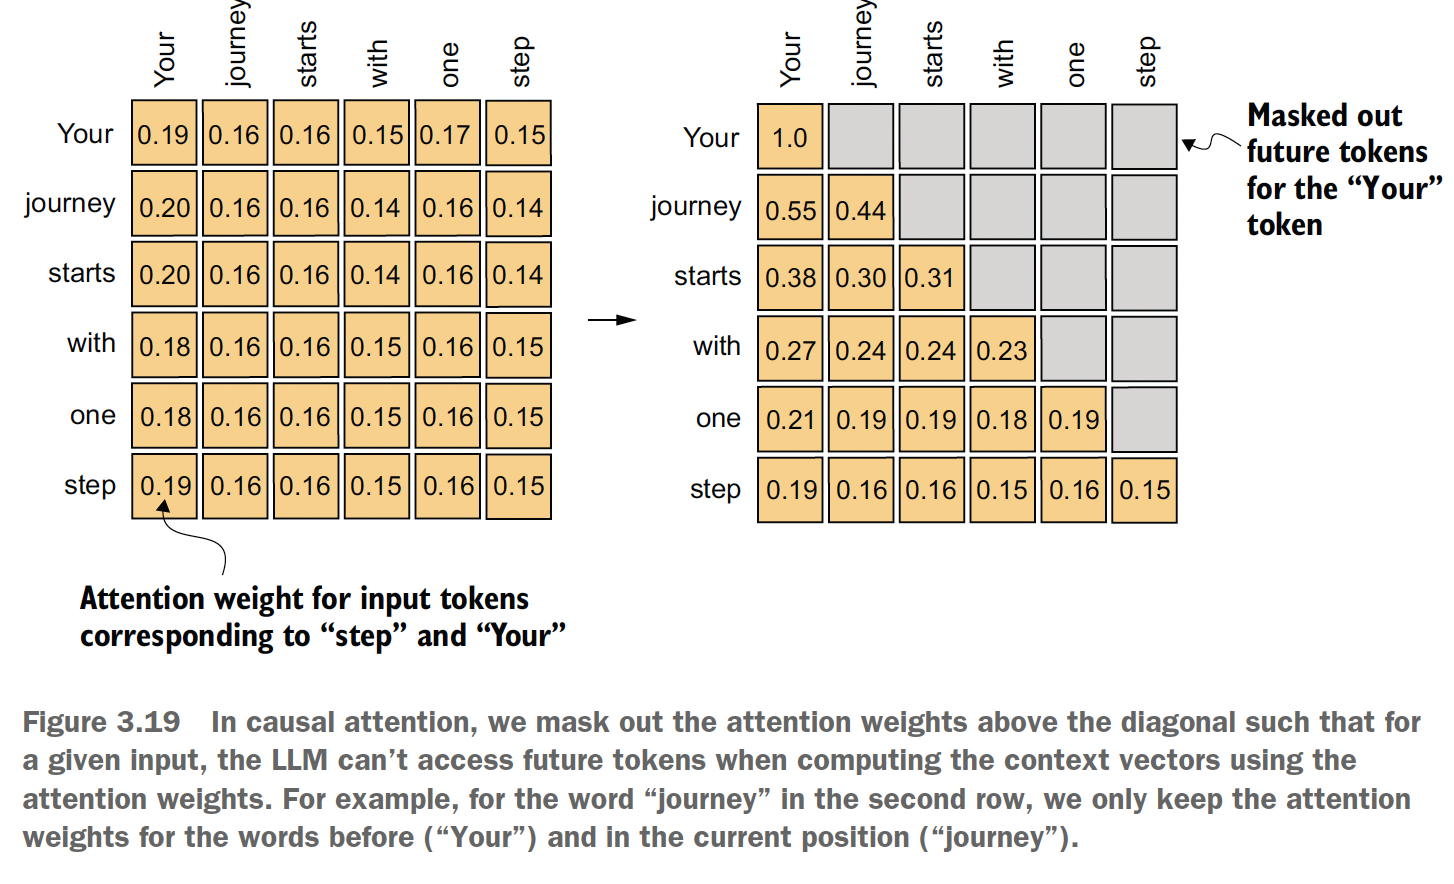

#### Why Causal Attention ? - 

#### Steps

Attention Scores  -> Apply Softmax -> Attention Weights(Normalized) -> 
 -> Mask with 0's above Diagonal -> Masked Attention Scores (Unnormalized) ->
 -> Normalize rows -> Masked Attention Weights (Normalized)

In [ ]:
# Using nn.Linear has optimized weight initialization scheme,
# leading better model training  (effective & Stable)
import torch
import torch.nn as nn

# input text - Your journey starts with one step
# [x_1, x_2, x_3, x_4, x_5, x_6] -> Tokenize input text (1, 6)
# Each token will have embedding dim of 3. Hence a input -> (6, 3)
inputs = torch.tensor(
[[0.43, 0.15, 0.89], # Your (x^1)
[0.55, 0.87, 0.66], # journey (x^2)
[0.57, 0.85, 0.64], # starts (x^3)
[0.22, 0.58, 0.33], # with (x^4)
[0.77, 0.25, 0.10], # one (x^5)
[0.05, 0.80, 0.55]] # step (x^6)
)

class SelfAttention_v2(nn.Module):
    def __init__(self, d_in, d_out, qkv_bias=False):
        # d_in - input dimension of the tokens
        # d_out - output dimension of the tokens
        super().__init__()
        self.W_q = nn.Linear(d_in, d_out, bias=qkv_bias) # (3, 2)
        self.W_k = nn.Linear(d_in, d_out, bias=qkv_bias) # (3, 2)
        self.W_v = nn.Linear(d_in, d_out, bias=qkv_bias) # (3, 2)

    def forward(self, x):
        queries = self.W_q(x) # (6, 3) @ (3, 2)
        keys = self.W_k(x) # -> (6, 2)
        values = self.W_v(x)

        attn_scores = queries @ keys.T # (6, 2) @ (2, 6) -> (6, 6)
        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1] ** 0.5, dim=-1
        )
        context_vec = attn_weights @ values # (6, 6) @ (6, 2) -> (6, 2)
        return context_vec

torch.manual_seed(123)
sa_v2 = SelfAttention_v2(3, 2)
print(sa_v2(inputs))
print(sa_v2(inputs).shape)

tensor([[-0.5337, -0.1051],
        [-0.5323, -0.1080],
        [-0.5323, -0.1079],
        [-0.5297, -0.1076],
        [-0.5311, -0.1066],
        [-0.5299, -0.1081]], grad_fn=<MmBackward0>)
torch.Size([6, 2])


##### 1.1 Applying a Causal Attention Mask

Intially it might appear that mask attention weights and renormalize might still have influence on the current token beacuse thier values are still part of softmax calculations, But since we are re-normalizing masked attention weights, we are essentialy doing is recalculating softmax over the smaller subset (Elegance of Softmax,) Therefor No Information Leakage

In [ ]:
# 1. Reuses the query and key weight matrices of the SelfAttention_v2 object
queries = sa_v2.W_q(inputs)
keys = sa_v2.W_k(inputs)
attention_scores = queries @ keys.T
attention_weights = torch.softmax(
    attention_scores / keys.shape[-1] ** 0.5, dim=-1
)
print(attention_weights)
#context_vectors = attention_weights @ sa_v2.W_v(inputs)

# 2. Pytorch's tril function to create a simple mask
context_length =  attention_scores.shape[0] 
simple_mask = torch.tril(torch.ones(context_length, context_length))
#print(simple_mask)

# To 0's the attention weights values above diagonal
masked_simple = attention_weights * simple_mask # Multiply
#print(masked_simple)

# 3. Renormalize attention weights to sum up to 1 again in each row
rows_sum = masked_simple.sum(dim=-1, keepdim=True)
masked_simple_norm = masked_simple / rows_sum
#print(masked_simple_norm)

# 4. A more efficient trick
# Softmax converts its input into a probability dist. large negative -> 0 
mask = torch.triu(torch.ones(context_length, context_length), diagonal=1)
masked = attention_scores.masked_fill(mask.bool(), -torch.inf) # large negative value

attention_weights = torch.softmax(masked / keys.shape[-1] ** 0.5, dim=-1)
print(attention_weights)

tensor([[0.1717, 0.1762, 0.1761, 0.1555, 0.1627, 0.1579],
        [0.1636, 0.1749, 0.1746, 0.1612, 0.1605, 0.1652],
        [0.1637, 0.1749, 0.1746, 0.1611, 0.1606, 0.1651],
        [0.1636, 0.1704, 0.1702, 0.1652, 0.1632, 0.1674],
        [0.1667, 0.1722, 0.1721, 0.1618, 0.1633, 0.1639],
        [0.1624, 0.1709, 0.1706, 0.1654, 0.1625, 0.1682]],
       grad_fn=<SoftmaxBackward0>)
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4833, 0.5167, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3190, 0.3408, 0.3402, 0.0000, 0.0000, 0.0000],
        [0.2445, 0.2545, 0.2542, 0.2468, 0.0000, 0.0000],
        [0.1994, 0.2060, 0.2058, 0.1935, 0.1953, 0.0000],
        [0.1624, 0.1709, 0.1706, 0.1654, 0.1625, 0.1682]],
       grad_fn=<SoftmaxBackward0>)


#### 1.2 Masking additonal attention weights with Dropout

Randomly selected hidden layer unit are ignored during trainig. Prevents overfitting such that it does not become over reliant on any specific hidden layer units.

Dropout in GPT is applied at two times - After calculating attention wieghts or after multiplying attention weights with value vectors

When we apply dropuout to attention weights, Half of the elements in attention wieght matrix is set to 0. To compensate for the reduction in elements, the values of remaining element is scaled  by factor of 1 / 0.5 = 2, to maintain overall balance of attention wieghts, ensurng average influence of attention mechanism remain consistent during both training and inference stages.

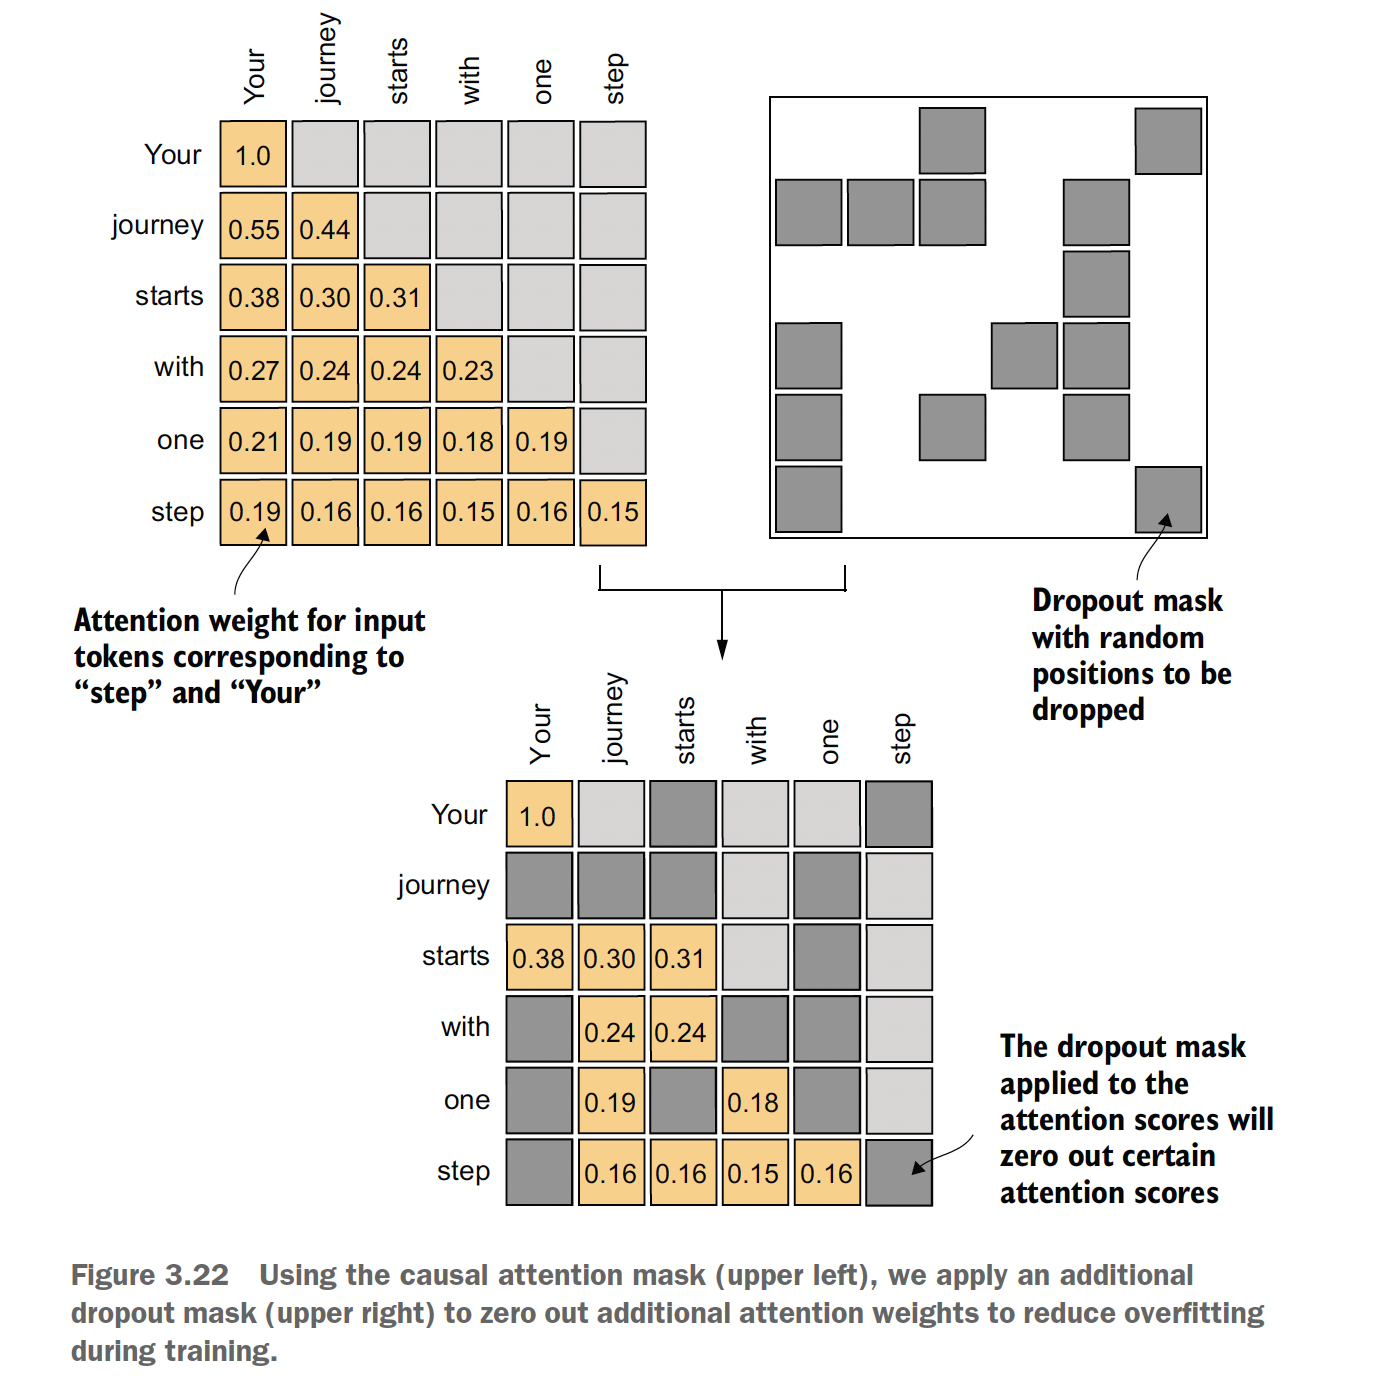

In [18]:
torch.manual_seed(123)
dropout = torch.nn.Dropout(0.5)
example = torch.ones(6, 6)
print(dropout(example))

print(dropout(attention_weights))

tensor([[2., 2., 0., 2., 2., 0.],
        [0., 0., 0., 2., 0., 2.],
        [2., 2., 2., 2., 0., 2.],
        [0., 2., 2., 0., 0., 2.],
        [0., 2., 0., 2., 0., 2.],
        [0., 2., 2., 2., 2., 0.]])
tensor([[2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.6816, 0.6804, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.5085, 0.4936, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.3906, 0.0000],
        [0.3249, 0.3418, 0.0000, 0.3308, 0.3249, 0.3363]],
       grad_fn=<MulBackward0>)


#### 1.3 Implementing a compact class



In [19]:
# 2 inputs with 6 token each. each tokem has dimension = 3
batch = torch.stack((inputs, inputs), dim=0) 
print(batch.shape)

torch.Size([2, 6, 3])


In [ ]:
class CausalAttention(nn.Module):
    def __init__(self, d_in, d_out,
                 context_length, dropout=0.5, qkv_bias=False):
        super().__init__()
        self.W_q = torch.nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_k = torch.nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_v = torch.nn.Linear(d_in, d_out, bias=qkv_bias)
        self.dropout = torch.nn.Dropout(dropout)
        self.register_buffer(
            'mask',
            torch.triu(torch.ones(context_length, context_length),
                        diagonal=1)
        )
        # buffers are automatically moved to appropiate device, along with our model
        # Hence no need to manually ensure that tensor on same device as model params

    def forward(self, x):
        b, num_tokens, d_in = x.shape # Keeping the batch at dimension  0
        queries = self.W_q(x)
        keys = self.W_k(x)
        values = self.W_v(x)

        attention_scores = queries @ keys.transpose(1, 2) # Transposing dim 1 and 2
        attention_scores.masked_fill_(
            self.mask.bool()[:num_tokens, :num_tokens], -torch.inf
        )# in PyTorch, Operation with trailing _ is performed in-place. 
        # Avoiding unnecessary memory copies

        attention_weights = torch.softmax(
            attention_scores / keys.shape[-1] ** 0.5, dim=-1
        )
        attention_weights = self.dropout(attention_weights)
        context_vec = attention_weights @ values

        return context_vec
    
torch.manual_seed(123)
context_length = batch.shape[1]
ca = CausalAttention(3, 2, context_length, 0.0)
context_vec = ca(batch)
print("context_vecs.shape", context_vec.shape)

context_vecs.shape torch.Size([2, 6, 2])
